In [1]:
! pip install pytorch-lightning pytorch_forecasting

     |████████████████████████████████| 527 kB 5.3 MB/s 
     |████████████████████████████████| 113 kB 46.7 MB/s 
     |████████████████████████████████| 133 kB 43.3 MB/s 
     |████████████████████████████████| 396 kB 42.2 MB/s 
     |████████████████████████████████| 952 kB 38.2 MB/s 
     |████████████████████████████████| 829 kB 43.6 MB/s 
     |████████████████████████████████| 596 kB 32.0 MB/s 
     |████████████████████████████████| 1.1 MB 36.3 MB/s 
     |████████████████████████████████| 308 kB 35.9 MB/s 
     |████████████████████████████████| 210 kB 35.7 MB/s 
     |████████████████████████████████| 80 kB 6.3 MB/s 
     |████████████████████████████████| 271 kB 34.9 MB/s 
     |████████████████████████████████| 144 kB 30.5 MB/s 
     |████████████████████████████████| 94 kB 2.9 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 149 kB 18.6 MB/s 
     |████████████████████████████████| 112 kB 4.3 MB/s 
     |████████████████

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

In [2]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

## Load Data

In [3]:
! ls 

bin	 datalab  home	 lib64	opt	    root  srv		     tmp    var
boot	 dev	  lib	 media	proc	    run   sys		     tools
content  etc	  lib32  mnt	python-apt  sbin  tensorflow-1.15.2  usr


In [4]:
data = pd.read_csv('/content/drive/MyDrive/final_preprocessed_data.csv')

In [5]:
data["Volume"].min()

0

In [6]:
data.head()

,Unnamed: 0,Plant,Material,Volume,Date,SalesTargetGroup,time_idx,month,log_volume,avg_volume_by_material,avg_volume_by_plant,timeseries
0,0,5M01,AI15570013TARCA20,0,2019-02-01,510,0,2,-18.420681,0.894737,4.139019,1
1,1,5M01,AI15570013TARCA20,0,2019-03-01,510,1,3,-18.420681,2.631579,5.979067,1
2,2,5M01,AI15570013TARCA20,0,2019-04-01,510,2,4,-18.420681,0.000000,3.668722,1
3,3,5M01,AI15570013TARCA20,0,2019-05-01,510,3,5,-18.420681,0.000000,3.691088,1
4,4,5M01,AI15570013TARCA20,0,2019-06-01,510,4,6,-18.420681,0.421053,4.763329,1


# Create dataset and dataloaders

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7363296 entries, 0 to 7363295
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Unnamed: 0              int64  
 1   Plant                   object 
 2   Material                object 
 3   Volume                  int64  
 4   Date                    object 
 5   SalesTargetGroup        object 
 6   time_idx                int64  
 7   month                   int64  
 8   log_volume              float64
 9   avg_volume_by_material  float64
 10  avg_volume_by_plant     float64
 11  timeseries              int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 674.1+ MB


In [25]:
data['Date']= pd.to_datetime(data['Date'])
data.drop(['Unnamed: 0'], axis=1, inplace=True)
for col in ['Plant', 'Material', 'SalesTargetGroup']:
    data[col] = data[col].astype(str).astype("category")
data['Volume'] = data['Volume'].astype(float)
data.drop(['month'], axis=1, inplace=True)
data["month"] = data.Date.dt.month.astype(str).astype("category")  # categories have be strings
data = data[data['timeseries'] != 202947 ]

In [18]:
data[data['avg_volume_by_plant'].isnull() == True]

,Plant,Material,Volume,Date,SalesTargetGroup,time_idx,log_volume,avg_volume_by_material,avg_volume_by_plant,timeseries,month


In [19]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Volume",
    group_ids=["Plant", "Material", "SalesTargetGroup"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Plant", "Material", "SalesTargetGroup"],
    static_reals=[],
    time_varying_known_categoricals=["month"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "Volume",
        "log_volume",
        "avg_volume_by_plant",
        "avg_volume_by_material",
    ],
    target_normalizer=GroupNormalizer(
        groups=["Plant", "Material", "SalesTargetGroup"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=False,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=1)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=1)

# Create baseline model

Evaluating a Baseline model that predicts the next 6 months by simply repeating the last observed volume gives us a simle benchmark that we want to outperform.


In [20]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

3.5348799228668213

# Train the Temporal Fusion Transformer

It is now time to create our TemporalFusionTransformer model. We train the model with PyTorch Lightning.


## Find optimal learning rate

Prior to training, you can identify the optimal learning rate with the PyTorch Lightning learning rate finder.

In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 29.7k


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1080: LightningDeprecationWarning:

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'

Global seed set to 42


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /lr_find_temp_model_b68b9044-2135-4544-966b-b8ffe03b040e.ckpt


suggested learning rate: 5.888436553555889e-06


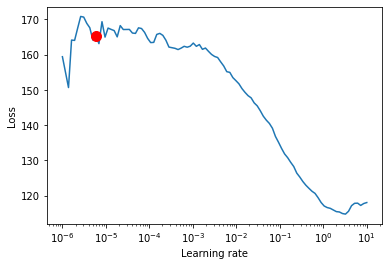

In [ ]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

For the TemporalFusionTransformer, the optimal learning rate seems to be slightly lower than the suggested one. Further, we do not directly want to use the suggested learning rate because PyTorch Lightning sometimes can get confused by the noise at lower learning rates and suggests rates far too low. Manual control is essential. We decide to pick 0.03 as learning rate.

# Train model


In [24]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=4,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=8,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 56.2k


During training, we can monitor the tensorboard which can be spun up with tensorboard --logdir=lightning_logs

In [25]:
# For AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [26]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:736: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  "`trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 48.0 K
3  | prescalers                         | ModuleDict                      | 128   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.0 K 
5  | encoder_variable_select

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Hyperparameter tuning

Hyperparamter tuning with [optuna](https://optuna.org/) is directly build into pytorch-forecasting. For example, we can use the optimize_hyperparameters() function to optimize the TFT’s hyperparameters.

In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=15, # Increase this later e.g. 200
    max_epochs=5, # Increase this later e.g. 50
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2022-01-10 09:31:22,743] A new study created in memory with name: no-name-67c66499-db70-44bc-86a5-2654f260276b
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning:

Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:168: LightningDeprecationWarning:

Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-package

{'gradient_clip_val': 0.061908031808036286, 'hidden_size': 42, 'dropout': 0.11049459988395656, 'hidden_continuous_size': 25, 'attention_head_size': 2, 'learning_rate': 0.023775610261741756}


# Evaluate performance
PyTorch Lightning automatically checkpoints training and thus, we can easily retrieve the best model and load it.

In [27]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

After training, we can make predictions with predict(). The method allows very fine-grained control over what it returns so that, for example, you can easily match predictions to your pandas dataframe.

We evaluate the metrics on the validation dataset and a couple of examples to see how well the model is doing. Given that we work with only 21 000 samples the results are very reassuring and can compete with results by a gradient booster. We also perform better than the baseline model. Given the noisy data, this is not trivial.


In [28]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(3.7784)

We can now also look at sample predictions directly which we plot with plot_prediction(). As you can see from the figures below, forecasts look rather accurate. If you wonder, the grey lines denote the amount of attention the model pays to different points in time when making the prediction. This is a special feature of the Temporal Fusion Transformer.

In [29]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

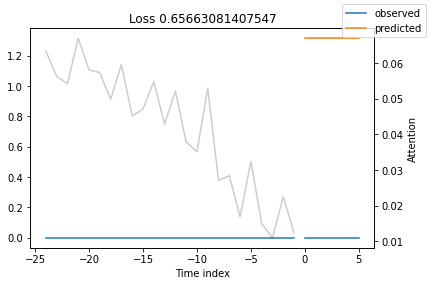

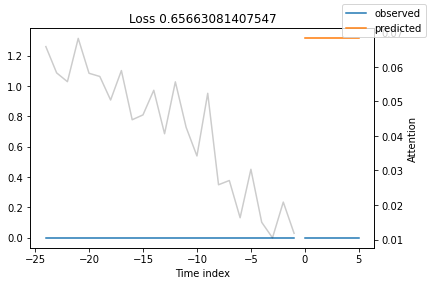

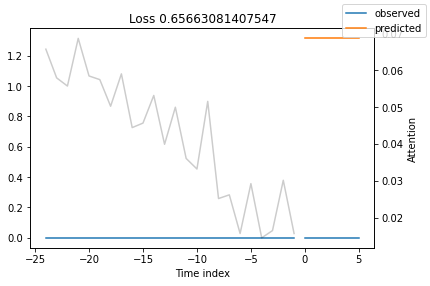

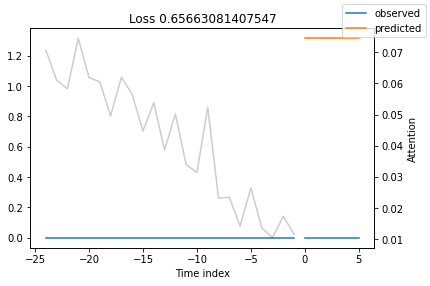

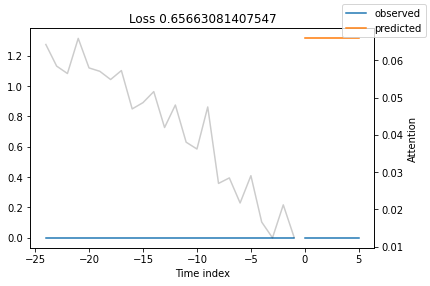

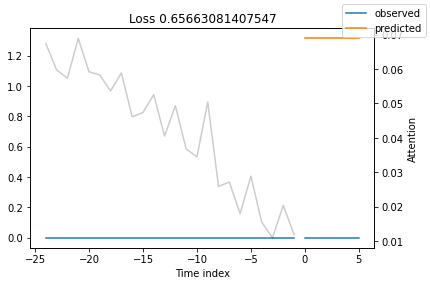

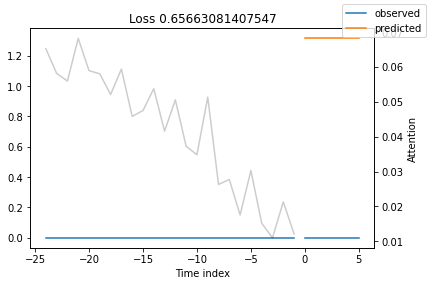

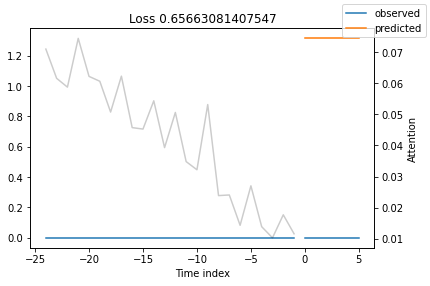

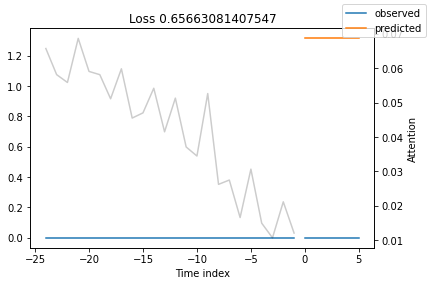

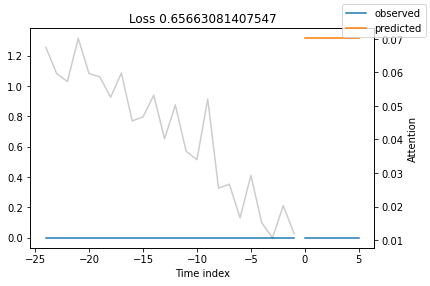

In [30]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

# Worst performers
Looking at the worst performers, for example in terms of SMAPE, gives us an idea where the model has issues with forecasting reliably. These examples can provide important pointers about how to improve the model. This kind of actuals vs predictions plots are available to all models. Of course, it is also sensible to employ additional metrics, such as MASE, defined in the metrics module. However, for the sake of demonstration, we only use SMAPE here.

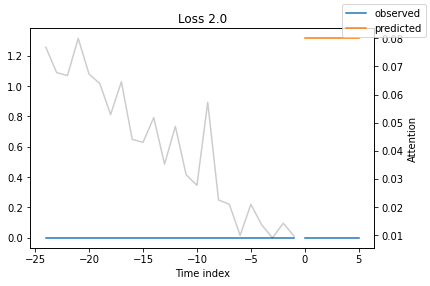

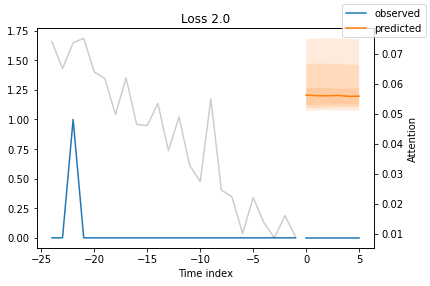

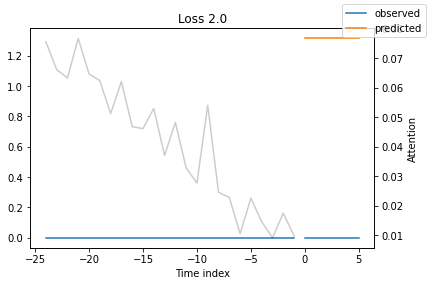

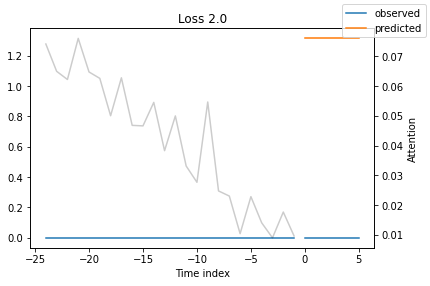

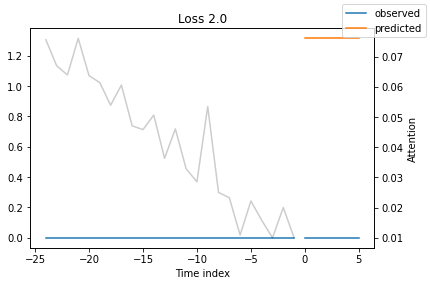

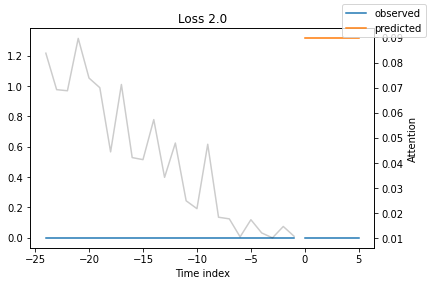

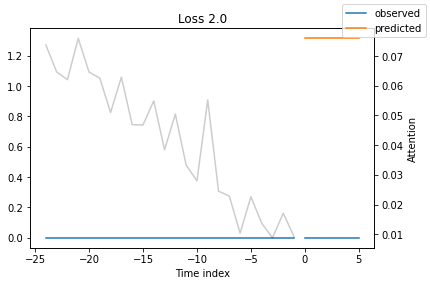

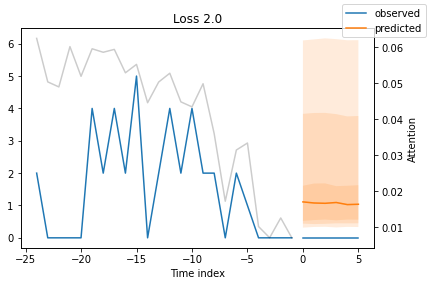

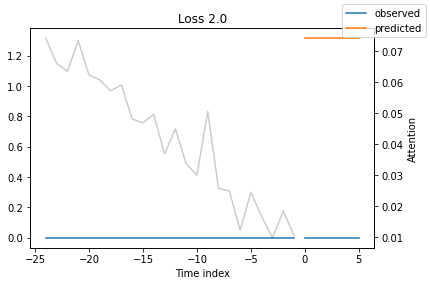

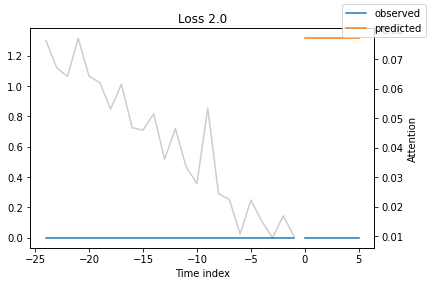

In [31]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

# Actuals vs predictions by variables
Checking how the model performs across different slices of the data allows us to detect weaknesses. Plotted below are the means of predictions vs actuals across each variable divided into 100 bins using the Now, we can directly predict on the generated data using the `calculate_prediction_actual_by_variable()` and `plot_prediction_actual_by_variable()` methods. The gray bars denote the frequency of the variable by bin, i.e. are a histogram.

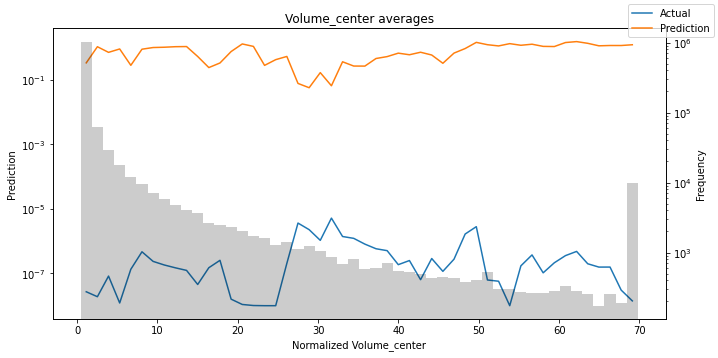

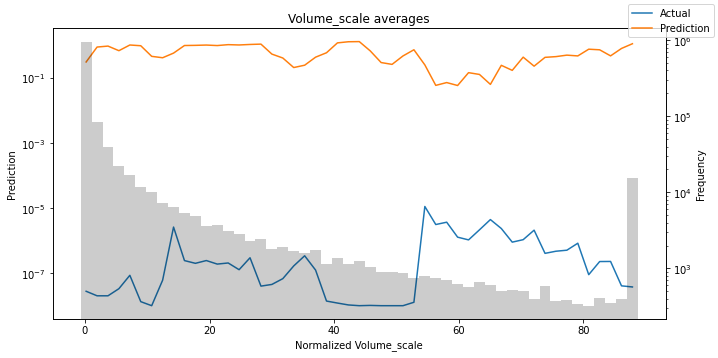

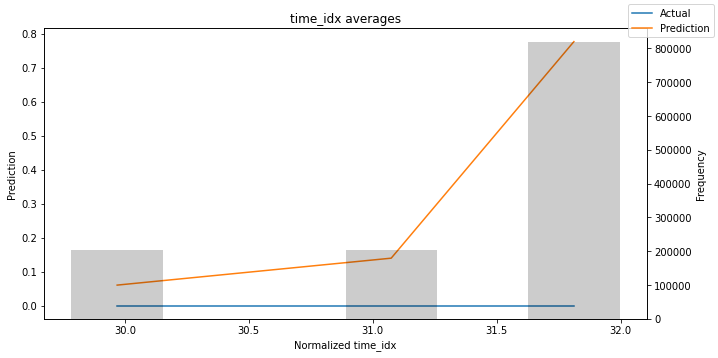

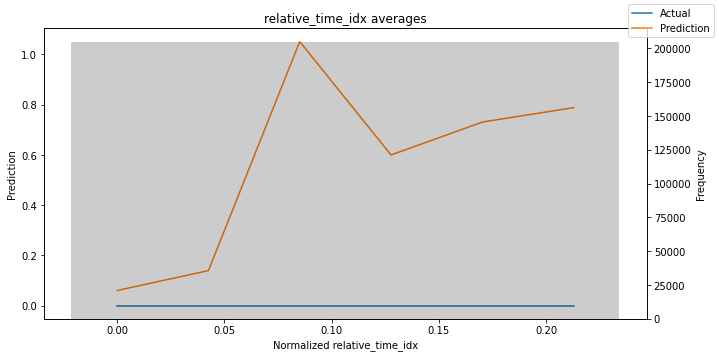

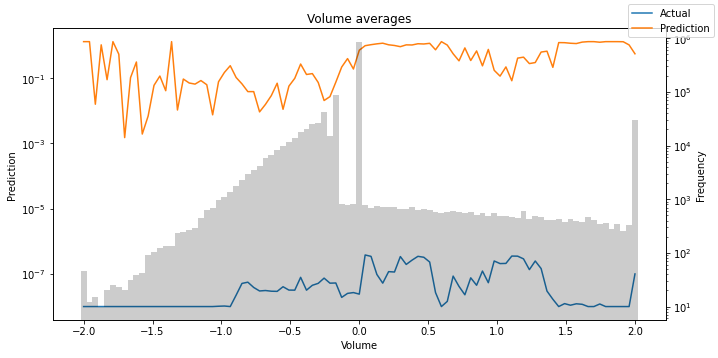

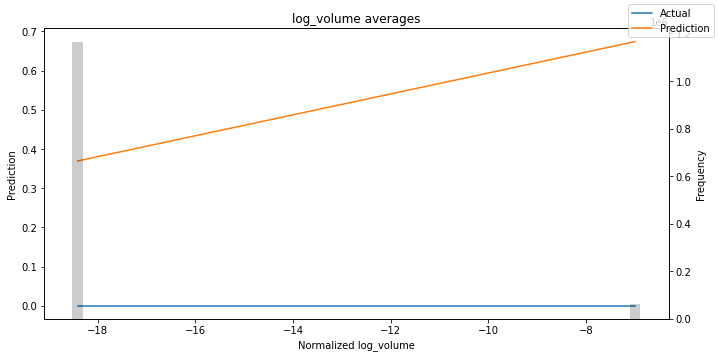

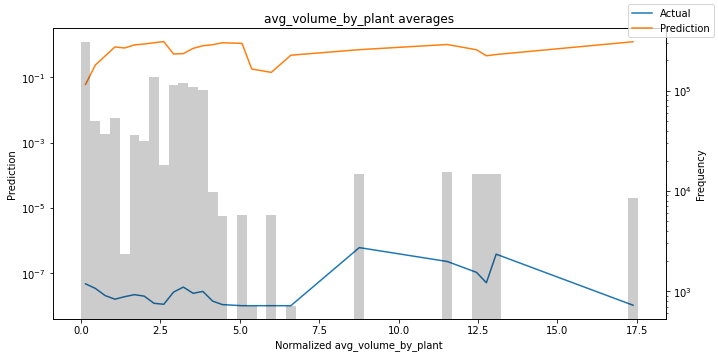

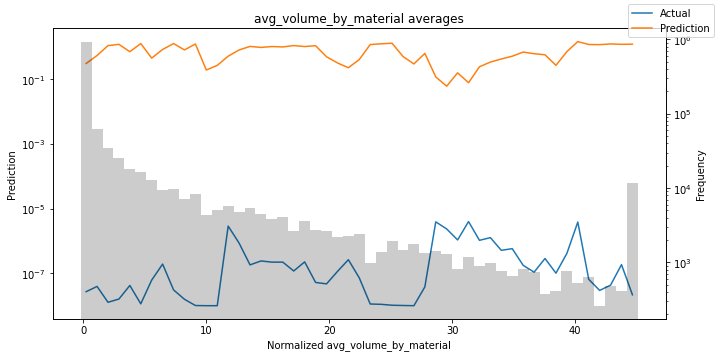

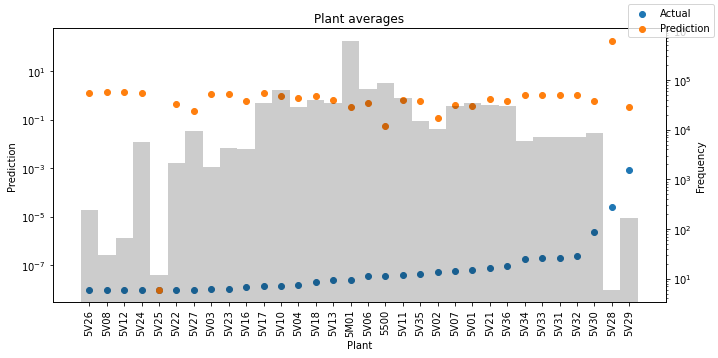

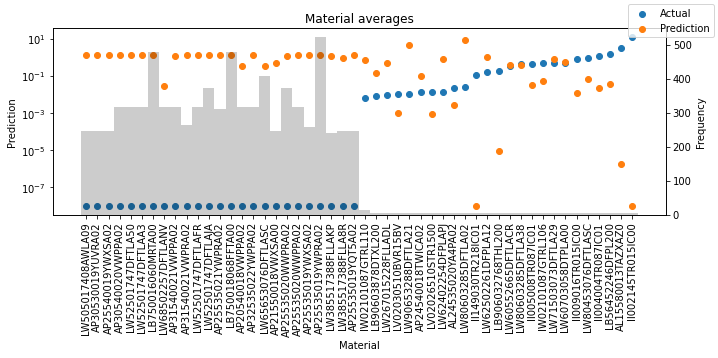

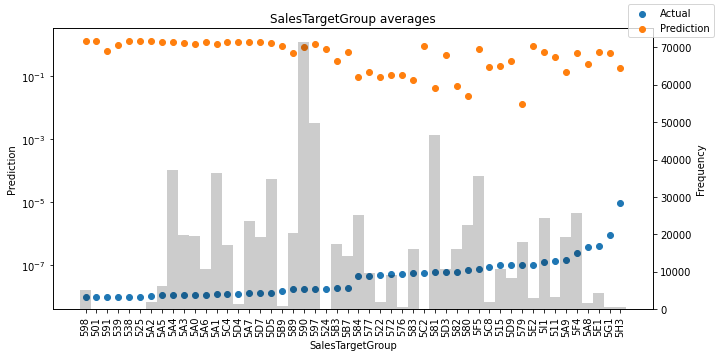

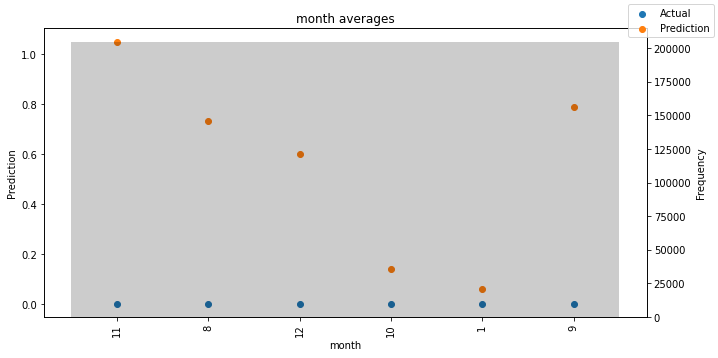

In [32]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

# Predict on selected data

To predict on a subset of data we can filter the subsequences in a dataset using the `filter()` method. Here we predict for the subsequence in the `training` dataset that maps to the group ids “Agency_01” and “SKU_01” and whose first predicted value corresponds to the time index “15”. We output all seven quantiles. This means we expect a tensor of shape `1 x n_timesteps x n_quantiles = 1 x 6 x 7` as we predict for a single subsequence six time steps ahead and 7 quantiles for each time step.



In [ ]:
best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="quantiles",
)

tensor([[[ 87.5199, 102.4650, 115.7096, 132.0083, 149.1013, 169.6897, 193.6455],
         [ 58.4002,  76.4457,  91.3999, 109.7849, 128.1937, 147.0569, 173.8937],
         [ 69.7947,  82.9872,  97.2082, 114.1146, 129.6361, 147.0599, 173.8797],
         [ 62.0514,  79.0255,  92.5546, 110.3650, 127.7684, 146.5691, 173.2462],
         [ 68.0198,  85.0037,  96.6666, 112.5465, 128.4262, 144.6257, 167.1694],
         [ 58.7913,  75.4096,  89.9839, 105.1501, 121.9040, 137.7739, 160.7249]]])

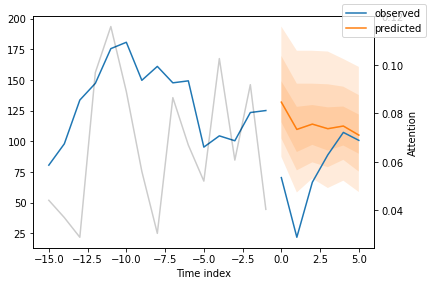

In [ ]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0);

# Predict on new data
Because we have covariates in the dataset, predicting on new data requires us to define the known covariates upfront.

In [ ]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

Now, we can directly predict on the generated data using the `predict()` method.

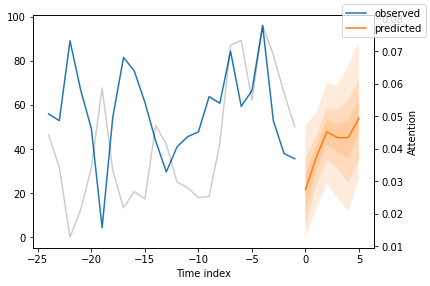

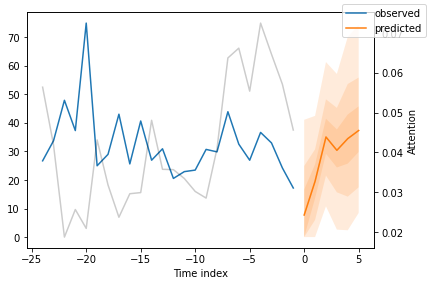

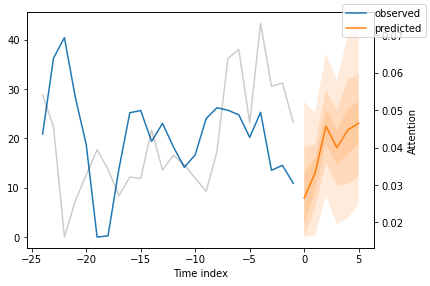

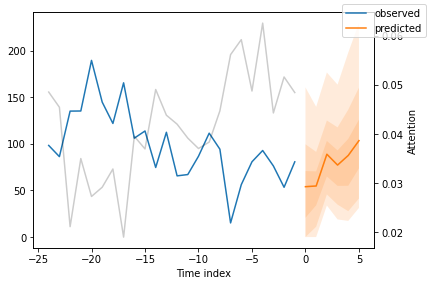

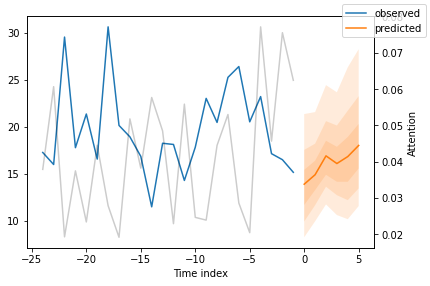

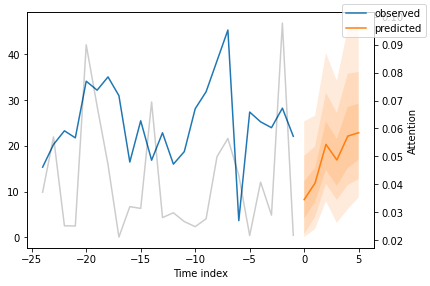

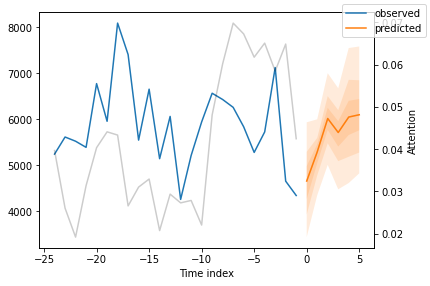

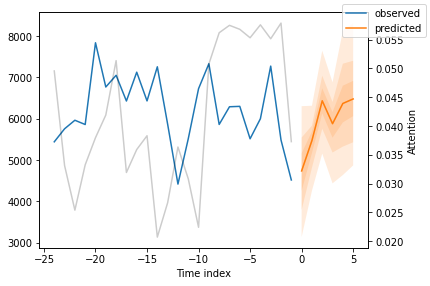

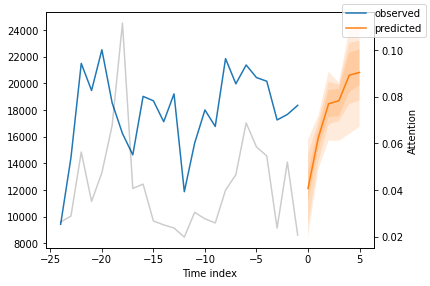

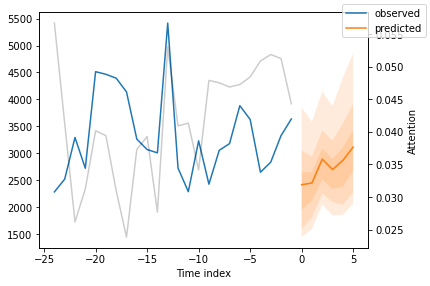

In [ ]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

# Interpret model
## Variable importances

The model has inbuilt interpretation capabilities due to how its architecture is build. Let’s see how that looks. We first calculate interpretations with `interpret_output()` and plot them subsequently with `plot_interpretation()`.

{'attention': <Figure size 432x288 with 1 Axes>,
 'decoder_variables': <Figure size 504x198 with 1 Axes>,
 'encoder_variables': <Figure size 504x270 with 1 Axes>,
 'static_variables': <Figure size 504x234 with 1 Axes>}

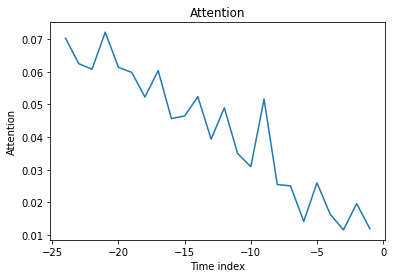

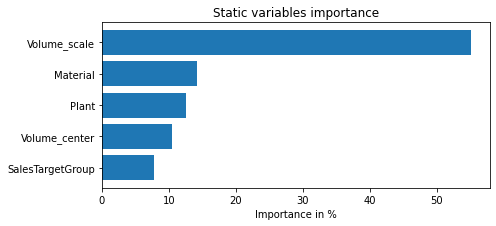

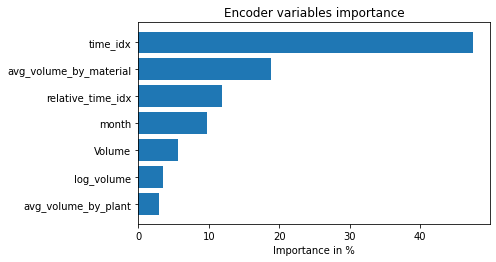

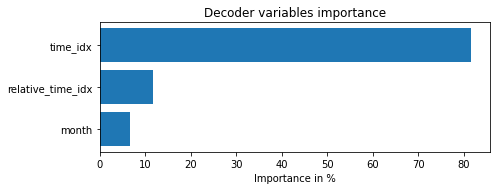

In [33]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

Unsurprisingly, the past observed volume features as the top variable in the encoder and price related variables are among the top predictors in the decoder.

The general attention patterns seems to be that more recent observations are more important and older ones. This confirms intuition. The average attention is often not very useful - looking at the attention by example is more insightful because patterns are not averaged out.

# Partial dependency
Partial dependency plots are often used to interpret the model better (assuming independence of features). They can be also useful to understand what to expect in case of simulations and are created with `predict_dependency()`.

In [ ]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset, "discount_in_percent", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

Predict:   0%|          | 0/30 [00:00<?, ? batches/s]

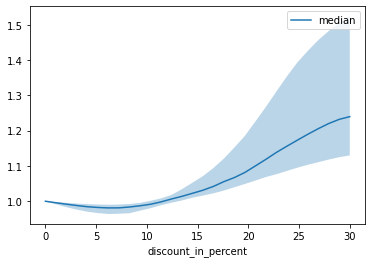

In [ ]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3);
